In [1]:
import csv
import itertools
import pandas as pd
import numpy as np
import networkx as nx

## Hypergraph to regular graph

In [10]:
papers=[]
with open("train.txt", "r") as f:
    for x in f:
        token_list=x.rstrip("\n").split()
        papers.append(token_list)

graph=[]

for paper in papers:
    for pair in itertools.combinations(paper, 2):
        graph.append(pair)

graph_df=pd.DataFrame(graph, columns=['Author_A','Author_B'])
#Calculate weights
g_df = graph_df.groupby(['Author_A','Author_B']).size().reset_index().rename(columns={0:'count'})
#create undirectional graph 
ng = nx.convert_matrix.from_pandas_edgelist(g_df, source= 'Author_A', target = 'Author_B', edge_attr= 'count')
print(nx.info(ng))
print(g_df)
authorlist_A = g_df['Author_A'].to_list()
authorlist_B = g_df['Author_B'].to_list()
authorlist.extend(authorlist_B)
authorlist = list(set(authorlist)) # remove duplicates
authorlist_A = list(set(authorlist_A)) # remove duplicates
authorlist_B = list(set(authorlist_B)) # remove duplicates

Name: 
Type: Graph
Number of nodes: 3767
Number of edges: 16036
Average degree:   8.5139
      Author_A Author_B  count
0            0     1236     14
1            0     1655      9
2            0     1797      4
3            0     2414      1
4            0     2568      8
...        ...      ...    ...
16031      999     2038      1
16032      999     2250      4
16033      999     2600      1
16034      999     2905      3
16035      999     3926      1

[16036 rows x 3 columns]


NameError: name 'authorlist' is not defined

In [18]:
#getting all set of edges
r = csv.reader(open('no_headers_graph_pos.csv','r'))
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1

## Create negative samples

In [19]:
%%time
###generating negative edges from given graph
import random

random.seed(1687)
missing_edges = set([])
while (len(missing_edges)<16036): # such that same number as positive edges
    a=random.choice(authorlist_A) # as the authorlist in the train set, contains all possible authors.
    b=random.choice(authorlist_B)
    tmp = edges.get((a,b),-1)
    if tmp == -1 and a!=b:
        try:
            if nx.shortest_path_length(ng,source=a,target=b) > 2 and (a,b) not in missing_edges and (b,a) not in missing_edges: 
                
                missing_edges.add((a,b))
            else:
                continue  
        except:
            if (a,b) not in missing_edges and (b,a) not in missing_edges:
                missing_edges.add((a,b))              
    else:
        continue

Wall time: 651 ms


In [20]:
print(len(missing_edges))
df_neg = pd.DataFrame(list(missing_edges), columns=['Author_A', 'Author_B'])
df_neg = df_neg.groupby(['Author_A','Author_B']).size().reset_index().rename(columns={0:'count'})
df_neg['Author_A'] = df_neg['Author_A'].astype(str)
df_neg['Author_B'] = df_neg['Author_B'].astype(str)

#Unnecesary step
ng_neg = nx.from_pandas_edgelist(df_neg, source= 'Author_A', target = 'Author_B', edge_attr= 'count')
print(df_neg)
df_pos = g_df
print(nx.info(ng_neg))
#sum(df_pos.duplicated())
y_pos = np.ones(len(df_pos))
y_neg = np.zeros(len(df_pos))

16036
      Author_A Author_B  count
0            0     1162      1
1            0     1626      1
2            0     2408      1
3            0     2519      1
4            0     2533      1
...        ...      ...    ...
16031      999     1658      1
16032      999     2536      1
16033      999     3161      1
16034      999     3296      1
16035      999     3735      1

[16036 rows x 3 columns]
Name: 
Type: Graph
Number of nodes: 3548
Number of edges: 16036
Average degree:   9.0395


### Comparing negative and positive graphs

!!!!!!!!!!!!!!!!!!!!!!!!!!! 
Although is not required to create a negative graph, as we need to calculate each negative edge as it was an edge in the orginal graph

#### Positive graph

In [15]:
nx.number_connected_components(ng)

142

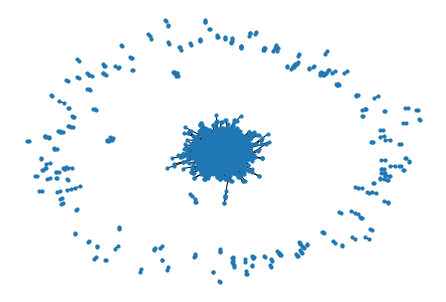

In [16]:
import matplotlib as plt
nx.draw_spring(ng,node_size = 10)

In [27]:
import matplotlib.pyplot as plt
import collections

def plot_degree(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color="b");

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg);


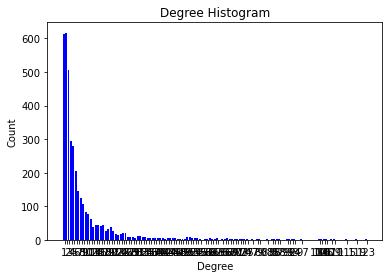

In [28]:
plot_degree(ng)

#### negative graph

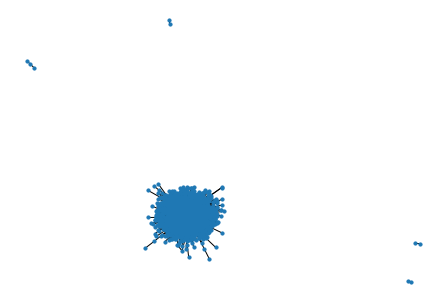

In [21]:
nx.draw_spring(ng_neg,node_size = 10)

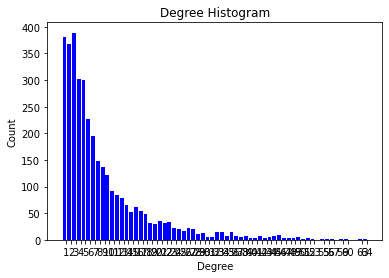

In [29]:
plot_degree(ng_neg)

## Calculate features

In [273]:
def feature_maker(edges):
    features = []
    for pair in edges:
        feat = []
        tmp_ng = ng.copy()
        
        #Add an edge to the network if node is not in training
        if not (ng.has_node(pair[0]) and ng.has_node(pair[1])):
            tmp_ng.add_edge(pair[0],pair[1])
        
        # Calculate features
        
        try:
            metric = nx.adamic_adar_index(tmp_ng, [pair])
            for s,t,m in metric:
                feat.append(m)
        except:
            feat.append(0)
        try:
            metric = nx.resource_allocation_index(tmp_ng, [pair])
            for s,t,m in metric:
                feat.append(m)
        except:
            feat.append(0)
        try:
            metric = nx.jaccard_coefficient(tmp_ng, [pair])
            for s,t,m in metric:
                feat.append(m)
        except:
            feat.append(0)
        try:
            metric = nx.preferential_attachment(tmp_ng, [pair])
            for s,t,m in metric:
                feat.append(m)
        except:
            feat.append(0)
            
        features.append(feat)
    return features       

In [274]:
test_df = pd.read_csv('test-public.csv')

In [275]:
#Positive instances
edges = [(i,e) for i,e in zip(df_pos.Author_A, df_pos.Author_B)]
feat = feature_maker(edges)
feat = pd.DataFrame(feat, columns = ['aa','ra','jc','pa'])
df_pos2 = pd.concat([df_pos, feat], axis = 1)

In [277]:
#NEgative instances
edges = [(i,e) for i,e in zip(df_neg.Author_A, df_neg.Author_B)]
feat = feature_maker(edges)
feat = pd.DataFrame(feat, columns = ['aa','ra','jc','pa'])
df_neg2 = pd.concat([df_pos, feat], axis = 1)

In [278]:
df_train = pd.concat([df_pos2, df_neg2], axis = 0)
df_train.to_csv('train_transformed.csv')

In [279]:
#Test set
edges = [(str(i),str(e)) for i,e in zip(test_df.Source, test_df.Sink)]
feat = feature_maker(edges)
feat = pd.DataFrame(feat, columns = ['aa','ra','jc','pa'])
test = pd.concat([test_df, feat], axis =1)   

test.to_csv('test_transformed.csv')

# OLD STUFF

In [ ]:
"""
tested features


"""
feature_1 = []
metric = nx.common_neighbor_centrality(ng)
for s,t in ng.edges():
    try:
        for u,v,p in metric:
            feature_1.append(p)
    except:
        feature_1.append(0)

katz = nx.katz.katz_centrality(ng)
# Katz centrality Author_A - doesn't converge.
feature_10 = []
for s,t in ng.edges():
    try:
        kc = katz[s]
        feature_10.append(kc)
    except:
        feature_10.append(0)

# Katz centrality Author_B
feature_11 = []
for s,t in ng.edges():
    try:
        kc = katz[t]
        feature_11.append(kc)
    except:
        feature_11.append(0)

katz = nx.katz.katz_centrality(ng_neg)
# Katz centrality Author_A neg edges.
feature_10_neg = []
for s,t in ng_neg.edges():
    try:
        kc = katz[s]
        feature_10_neg.append(kc)
    except:
        feature_10_neg.append(0)

# Katz centrality Author_B neg edges.
feature_11_neg = []
for s,t in ng_neg.edges():
    try:
        kc = katz[t]
        feature_11_neg.append(kc)
    except:
        feature_11_neg.append(0)

In [34]:
def extract_feats(g, ds = 'train'):
    btwc = nx.edge_betweenness_centrality(g)
    feature_2 = []
    feature_3 = []
    cc = nx.closeness_centrality(g)
    feature_4 = []
    dc = nx.degree_centrality(g)
    feature_5 = []
    feature_6 = []
    feature_7 = []
    pr = nx.pagerank(g)
    # pagerank Author_A.
    feature_8 = []
    # pagerank Author_B.
    feature_9 = []
    hits = nx.hits(g, max_iter=500)
    # for Author A.
    feature_12 = []
    feature_13 = []
    # for Author B.
    feature_14 = []
    feature_15 = []
    
    for s,t in g.edges():
        if g.get_edge_data(s, t)['dataset'] == ds:
            try:
                feature_2.append(btwc[(str(s),str(t))])
                metric = nx.adamic_adar_index(g, [(s,t)])

                for u,v,p in metric:
                    feature_3.append(p)
                feature_4.append(cc[str(s)])
                feature_5.append(dc[str(s)])

                metric = nx.jaccard_coefficient(g, [(s,t)])
                for u,v,p in metric:
                    feature_6.append(p)
                metric = nx.preferential_attachment(g, [(s,t)])
                for u,v,p in metric:
                    feature_7.append(p)
                rank = pr[s]
                feature_8.append(rank)
                rank = pr[t]
                feature_9.append(rank)
                hit_i = hits[0][s]
                hit_j = hits[1][s]
                feature_12.append(hit_i)
                feature_13.append(hit_j)
                hit_i = hits[0][t]
                hit_j = hits[1][t]
                feature_14.append(hit_i)
                feature_15.append(hit_j)
            except:
                feature_2.append(0)
                feature_3.append(0)
                feature_4.append(0)
                feature_5.append(0)
                feature_6.append(0)
                feature_7.append(0)
                feature_8.append(0)
                feature_9.append(0)
                feature_12.append(0)
                feature_13.append(0)
                feature_14.append(0)
                feature_15.append(0)
    return feature_2, feature_3, feature_4, feature_5, feature_6, feature_7, feature_8, feature_9, feature_12, feature_13, feature_14, feature_15  


# need "community" information for that. Do we have that piece of information?
#wic = nx.within_inter_cluster(ng)

In [ ]:
#df_pos['cnc'] = feature_1
df_pos['btwc'] = feature_2(ng)
df_pos['adar'] = feature_3(ng)
df_pos['cc'] = feature_4(ng)
df_pos['dc'] = feature_5(ng)
df_pos['jc'] = feature_6(ng)
df_pos['pa'] = feature_7(ng)
df_pos['pagerank_A'] = feature_8(ng)
df_pos['pagerank_B'] = feature_9(ng)
#df_pos['katz_A'] = feature_10
#df_pos['katz_B'] = feature_11
df_pos['hits_authority_A'], df_pos['hits_hubs_A'] = feature_12_13(ng)
df_pos['hits_authority_B'], df_pos['hits_hubs_B'] = feature_14_15(ng)
#df_neg['cnc'] = feature_1_neg
df_neg['btwc'] = feature_2(ng_neg)
df_neg['adar'] = feature_3(ng_neg)
df_neg['cc'] = feature_4(ng_neg)
df_neg['dc'] = feature_5(ng_neg)
df_neg['jc'] = feature_6(ng_neg)
df_neg['pa'] = feature_7(ng_neg)
df_neg['pagerank_A'] = feature_8(ng_neg)
df_neg['pagerank_B'] = feature_9(ng_neg)
#df_neg['katz_A'] = feature_10_neg
#df_neg['katz_B'] = feature_11_neg
df_neg['hits_authority_A'], df_neg['hits_hubs_A'] = feature_12_13(ng_neg)
df_neg['hits_authority_B'], df_neg['hits_hubs_B'] = feature_14_15(ng_neg)

In [152]:
import pickle
df_pos.to_csv("pos_training_data.csv")
df_neg.to_csv("neg_training_data.csv")
with open('pos_training_labels.ob', 'wb') as fp:
    pickle.dump(y_pos, fp)
with open('neg_training_labels.ob', 'wb') as fp:
    pickle.dump(y_neg, fp)
df_final_train = df_pos.append(df_neg,ignore_index=True)
y_final_train = np.concatenate((y_pos,y_neg))
df_final_train.to_csv("training_data_combined.csv")
with open('training_labels_combined.ob', 'wb') as fp:
    pickle.dump(y_final_train, fp)

In [ ]:
df_final_train = pd.read_csv("training_data_combined.csv")

### Transform test set

#### First try of gettin mixing test and train network to calculate features properly. Didnt work

In [82]:
# public test data transformation.
for s,t in ng.edges():
    nx.set_edge_attributes(ng, {(s,t):{'dataset':'train'}})
test_df = pd.read_csv('test-public.csv')
test_df.drop(test_df.columns[[0]], axis=1, inplace=True)
test_df.columns = ['Author_A','Author_B']
test_df = test_df.groupby(['Author_A','Author_B']).size().reset_index().rename(columns={0:'count'})
test_df['dataset'] = ['test' for i in range(test_df.shape[0])]
#create undirectional graph 
ng_test = nx.convert_matrix.from_pandas_edgelist(test_df, source= 'Author_A', target = 'Author_B', edge_attr= ['count','dataset'])
ng_test = nx.union(ng,ng_test)

test_df['btwc'], test_df['adar'], test_df['cc'], test_df['dc'], test_df['jc'], test_df['pa'], test_df['pagerank_A'], test_df['pagerank_B'],test_df['hits_authority_A'], test_df['hits_hubs_A'],test_df['hits_authority_B'], test_df['hits_hubs_B']  = extract_feats(ng_test, 'test')

KeyboardInterrupt: 